# Morkov Models 

#### The simplest Markov models assume that we have a system that contains a finite set of states, and that the system transitions between these states with some probability at each time step t, thus generating a sequence of states over time. Let's call these states S, where

S={s1,s2,...,sn}
To keep things simple, let's start with three states:

S={s1,s2,s3}
A Markov model generates a sequence of states, with one possible realization being:

{s1,s1,s1,s3,s3,s3,s2,s2,s3,s3,s3,s3,s1,...}
And generically, we represent it as a sequence of states xt,xt+1...xt+n. (We have chosen a different symbol to not confuse the "generic" state with the specific realization.

### Initializing a Markov chain
Every Markov chain needs to be initialized. To do so, we need an initial state probability vector, which tells us what the distribution of initial states will be. Let's call the vector pS, where the subscript S indicates that it is for the "states".

pinit=(p1p2p3)
Semantically, they allocate the probabilities of starting the sequence at a given state. For example, we might assume a discrete uniform distribution
Modelling transitions between states
To know how a system transitions between states, we now need a transition matrix. The transition matrix describes the probability of transitioning from one state to another. (The probability of staying in the same state is semantically equivalent to transitioning to the same state.)

By convention, transition matrix rows correspond to the state at time t, while columns correspond to state at time t+1. Hence, row probabilities sum to one, because the probability of transitioning to the next state depends on only the current state, and all possible states are known and enumerated.

Let's call the transition matrix Ptransition. The symbol etymology, which usually gets swept under the rug in mathematically-oriented papers, are as follows:

transition doesn't refer to time but simply indicates that it is for transitioning states,
P is used because it is a probability matrix.
Ptransition=[[],[],[]]
Using the transition matrix, we can express that the system likes to stay in the state that it enters into, by assigning larger probability mass to the diagonals. Alternatively, we can express that the system likes to transition out of states that it enters into, by assigning larger probability mass to the off-diagonal.


In [6]:
# consider a example of brand loyality or brand switching 
import numpy as np
p_init=np.array([0.1,0.8,0.1])  # brand A has the 10% market share, brand B has 80% market share and brand C has 10% market share 

In [7]:
# transition matrix between brand switching is follows 

p_transition = np.array([[0.9,0.05,0.05],[0.01,0.9,0.09],[0.07,0.03,0.9]])

In [8]:
# next time period brnad shares will be 

p_next=p_init@p_transition

In [9]:
p_next

array([0.105, 0.728, 0.167])

In [19]:
# now will chk for 200 time period 

p_state_t=[p_init]
for i in range(200):
    
    p_next=p_state_t[-1]@p_transition
    p_state_t.append(p_next)


In [22]:
import pandas as pd
state_distribution=pd.DataFrame(p_state_t)

In [23]:
state_distribution

,0,1,2
0,0.100000,0.800000,0.100000
1,0.105000,0.728000,0.167000
2,0.113470,0.665460,0.221070
3,0.124253,0.611220,0.264528
4,0.136456,0.564246,0.299297
...,...,...,...
196,0.313305,0.278970,0.407725
197,0.313305,0.278970,0.407725
198,0.313305,0.278970,0.407725
199,0.313305,0.278970,0.407725


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

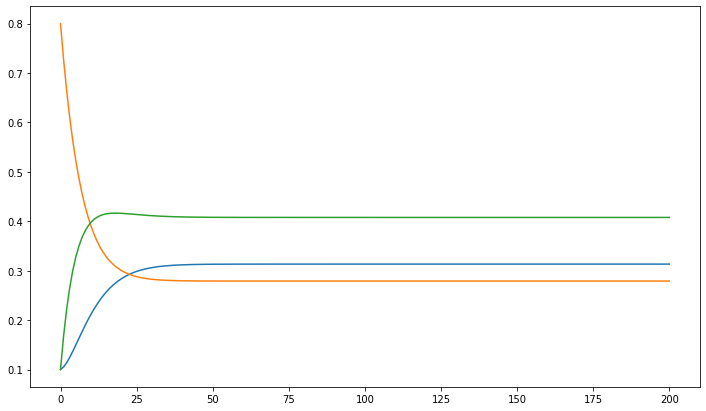

In [26]:
plt.figure(figsize=(12,7))
plt.plot(state_distribution)
plt.show()

## Generating a Markov Sequence
Generating a Markov sequence means we "forward" simulate the chain by:

##### (1) Optionally drawing an initial state from pS (let's call that st). This is done by drawing from a multinomial distribution:

st∼Multinomial(1,pS)
If we assume (and keep in mind that we don't have to) that the system was equilibrated before we started observing its state sequence, then the initial state distribution is equivalent to the equilibrium distribution. All this means that we don't necessarily have to specify the initial distribution explicitly.

##### (2) Drawing the next state by indexing into the transition matrix pT, and drawing a new state based on the Multinomial distribution:

st+1∼Multinomial(1,pTi)
where i is the index of the state.

I previously wrote about what probability distributions are, leveraging the SciPy probability distributions library. We're going to use that extensively here, as opposed to NumPy's random module, so that we can practice getting familiar with probability distributions as objects.

In [49]:
from scipy.stats import multinomial

def markov_sequence(p_init,p_transition,sequence_length):
    if p_init is None:
        p_init=equilibrium_distribution(p_transition)
    initial_state=list(multinomial.rvs(1,p_init)).index(1)
    
    state=[initial_state]
    for i in range(sequence_length-1):
        p_tran=p_transition[state[-1]]
        new_state=list(multinomial.rvs(1,p_tran)).index(1)
        state.append(new_state)
    return state

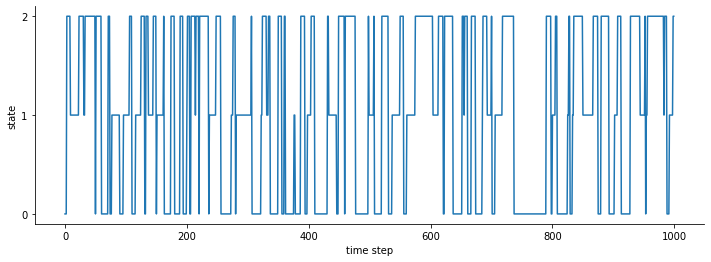

In [52]:
states = markov_sequence(p_init, p_transition, sequence_length=1000)
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(states)
plt.xlabel("time step")
plt.ylabel("state")
plt.yticks([0, 1, 2])
sns.despine()

## Gaussian Emissions: When Markov chains emit Gaussian-distributed data.

#### With a three state model, we might say that the emissions are Gaussian distributed, but the location (μ) and scale (σ) vary based on which state we are in. In the simplest case:

##### State 1 gives us data y1∼N(μ=1,σ=0.2)
##### State 2 gives us data y2∼N(μ=0,σ=0.5)
##### State 3 gives us data y3∼N(μ=−1,σ=0.1)

In [56]:
from scipy.stats import norm

def gaussian_emissions(states:list[int],mus:list[float],sigmas:list[float]):
    emissions = []
    for state in states:
        loc = mus[state]
        scale = sigmas[state]
        e = norm.rvs(loc=loc, scale=scale)
        emissions.append(e)
    return emissions

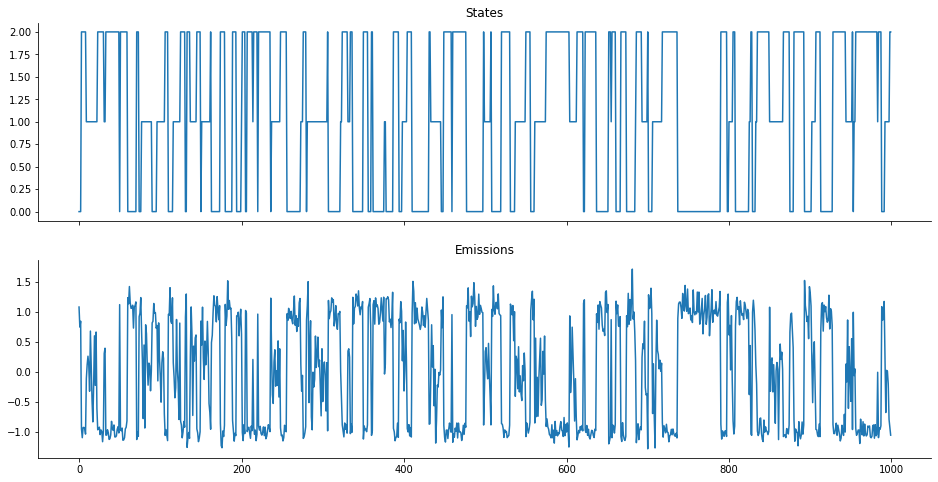

In [83]:
gaussian_ems = gaussian_emissions(states, mus=[1, 0, -1], sigmas=[0.2, 0.5, 0.1])

def plot_emissions(states, emissions):
    fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=1, sharex=True)

    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    sns.despine();

plot_emissions(states, gaussian_ems)

## monte Carlo Simulation

In [161]:
# define simulator 

# we required average return, standerd deviation of return, last share price, no of itterations

from scipy.stats import norminvgauss, invgauss

pred=[]

def prediction(price,ar,sdr,itt):
    
    for i in range(itt):
        
        rv=invgauss.mean(np.random.rand(1), loc=ar, scale=sdr)
        pp=price*np.exp(rv)
        pred.append(pp)
    return pred

# norminvgauss.ppf(np.random.rand(),loc=1.1,scale=1.8)

In [172]:
new_pred=prediction(37.6,0.002119,0.047904,10000)

print(np.max(new_pred))
print(np.min(new_pred))
print(np.percentile(new_pred,10))
print(np.percentile(new_pred,50))
print(np.percentile(new_pred,90))

39.52864513263124
37.68011076657729
37.86269678714164
38.58515505238138
39.339088924983116


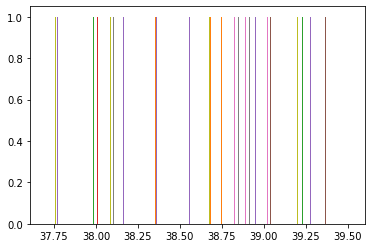

In [173]:
#sns.distplot(new_pred,bins=30)
#plt.hist(new_pred)
#plt.show()

In [174]:
dd=pd.DataFrame(new_pred)

In [175]:
dd.head(), dd.shape

(           0
 0  37.773270
 1  38.662930
 2  39.024545
 3  38.867135
 4  39.189456,
 (11000, 1))

In [176]:
print(type(ar_pred))

<class 'numpy.ndarray'>


In [177]:
ar_pred=np.array(new_pred)

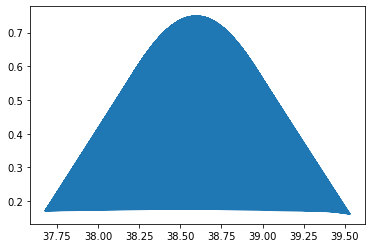

In [178]:
from scipy.stats import norm
plt.plot(ar_pred,norm.pdf(x=ar_pred,loc=np.mean(ar_pred),scale=np.std(ar_pred)))
plt.show()